# CNN Model

### 1. Import Libraries

In [2]:
# Import necessary libraries
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime

### 2. Global Variables
most of the changes are done here

In [3]:
# Dataset paths
data_dir = 'E:\\M15_PoC\\Dataset\\RDI Dataset\\PreProcessed\\'

# Define categories
categories = ['Justsaturated','Undersaturated','Oversaturated']

# Define split ratios
train_ratio = 0.70
val_ratio = 0.15  # Remaining 15% is for test

# Model path
MODEL_PATH = 'E:\\M15_PoC\\Models\\'

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 240, 670

# Define batch size and epochs
BATCH_SIZE = 32 
EPOCHS = 20

### 3. Utility Functions

In [4]:
def check_directory(directory):
    if os.path.exists(directory):
        print(f"{directory} exists.")
    else:
        print(f"{directory} does not exist.")

In [5]:
def split_data(data_dir, categories, train_ratio, val_ratio):
    # Check directory
    check_directory(data_dir)
    
    # Define directories
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')
    
    # Create directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    total_train, total_val, total_test = 0, 0, 0

    # Loop through each category and split the data
    for cat in categories:
        cat_dir = os.path.join(data_dir, cat)
        img_files = os.listdir(cat_dir)
        random.shuffle(img_files)  # shuffle the list of image files

        train_files = img_files[:int(len(img_files) * train_ratio)]
        val_files = img_files[int(len(img_files) * train_ratio):int(len(img_files) * (train_ratio + val_ratio))]
        test_files = img_files[int(len(img_files) * (train_ratio + val_ratio)):]

        for d in [(train_files, train_dir), (val_files, val_dir), (test_files, test_dir)]:
            os.makedirs(os.path.join(d[1], cat), exist_ok=True)
            for fname in d[0]:
                shutil.copy(os.path.join(cat_dir, fname), os.path.join(d[1], cat, fname))

        total_train += len(train_files)
        total_val += len(val_files)
        total_test += len(test_files)

    return train_dir, val_dir, test_dir, total_train, total_val, total_test

In [6]:
def get_data_generators(train_dir, val_dir, test_dir):
    # Preprocess the images
    # Introduce data augmentation to the training set
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range=20,
        width_shift_range=0.2, 
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    # We do not apply any augmentation on validation data
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    return train_generator, val_generator, test_generator

In [7]:
def get_model():
    # Define the model
    model = Sequential([
        Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(),
        Dropout(0.2),  
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.3),  
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.4),  
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # added L2 regularization, originally 0.001
        Dropout(0.5),  
        Dense(3)  # number of classes
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [8]:
def train_model(model, train_generator, val_generator, total_train, total_val):
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=2,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights from the epoch with the best value
    )
    
    history = model.fit(
        train_generator,
        steps_per_epoch=total_train // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=total_val // BATCH_SIZE,
        callbacks=[early_stopping]
    )

    return history


In [9]:
def plot_training_progress(history):
    # Plotting the training progress
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [10]:
def save_model(model, history, total_train, total_val):
    # Save the model and rename according to the number of epochs and timestamp
    now = datetime.datetime.now()
    model_name = 'model_' + str(EPOCHS) + '_' + now.strftime("%Y%m%d-%H%M%S") + '.h5'
    model.save(MODEL_PATH + model_name)

    # Generate a txt file with detailed information about the model
    with open(MODEL_PATH + model_name + '.txt', 'w') as f:
        f.write('Model name: ' + model_name + '\n')
        f.write('Number of epochs: ' + str(EPOCHS) + '\n')
        f.write('Batch size: ' + str(BATCH_SIZE) + '\n')
        f.write('Image height: ' + str(IMG_HEIGHT) + '\n')
        f.write('Image width: ' + str(IMG_WIDTH) + '\n')
        f.write('Total training images: ' + str(total_train) + '\n')
        f.write('Total validation images: ' + str(total_val) + '\n')
        f.write('Training accuracy: ' + str(history.history['accuracy'][-1]) + '\n')
        f.write('Validation accuracy: ' + str(history.history['val_accuracy'][-1]) + '\n')
        f.write('Training loss: ' + str(history.history['loss'][-1]) + '\n')
        f.write('Validation loss: ' + str(history.history['val_loss'][-1]) + '\n')
        f.write('Timestamp: ' + now.strftime("%Y%m%d-%H%M%S") + '\n')
        f.write('Model summary: ' + '\n')
        model.summary(print_fn=lambda x: f.write(x + '\n'))  # save model summary to txt file


### 4. Main Functions
Do not change anything here

E:\M15_PoC\Dataset\RDI Dataset\PreProcessed\ exists.
Found 11546 images belonging to 3 classes.
Found 2474 images belonging to 3 classes.
Found 2475 images belonging to 3 classes.
Epoch 1/20
360/360 [==============================] - 1072s 3s/step - loss: 0.6040 - accuracy: 0.8275 - val_loss: 0.3166 - val_accuracy: 0.9493
Epoch 2/20
360/360 [==============================] - 1454s 4s/step - loss: 0.4386 - accuracy: 0.8769 - val_loss: 0.2743 - val_accuracy: 0.9517
Epoch 3/20
360/360 [==============================] - 1063s 3s/step - loss: 0.3890 - accuracy: 0.8901 - val_loss: 0.2468 - val_accuracy: 0.9509
Epoch 4/20
360/360 [==============================] - 1029s 3s/step - loss: 0.3556 - accuracy: 0.9062 - val_loss: 0.2142 - val_accuracy: 0.9521
Epoch 5/20
360/360 [==============================] - 1009s 3s/step - loss: 0.3406 - accuracy: 0.9130 - val_loss: 0.6365 - val_accuracy: 0.8782
Epoch 6/20
360/360 [==============================] - 1010s 3s/step - loss: 0.3209 - accuracy: 0.918

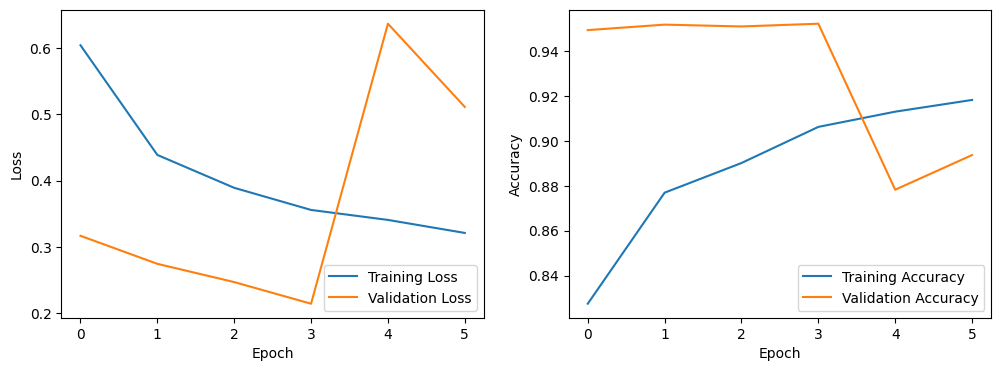

In [11]:
def main():
    train_dir, val_dir, test_dir, total_train, total_val, total_test = split_data(
        data_dir, categories, train_ratio, val_ratio)
    train_generator, val_generator, test_generator = get_data_generators(
        train_dir, val_dir, test_dir)
    model = get_model()
    history = train_model(model, train_generator, val_generator, total_train, total_val)
    plot_training_progress(history)
    save_model(model, history, total_train, total_val)


if __name__ == "__main__":
    main()